# Data v2
Here, I calculate VAP growth rates for each demographic group for each state by using a simple regression on Census data.

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import json

%matplotlib inline
from IPython.display import display

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [89]:
# load data
pop_est = pd.read_csv('2014_pop_est.csv')

# replace codes with strings
fips_codes = pd.read_csv('state_fips_codes.csv').set_index('FIPS State Numeric Code')
fips_codes.columns = ['state_name', 'postal_code']
pop_est = pd.merge(pop_est, fips_codes, left_on='STATE', right_index=True)
sex = {
    0: 'total',
    1: 'male',
    2: 'female',
}
origin = {
    0: 'total',
    1: 'non-hispanic',
    2: 'hispanic',
}
race = {
    1: 'white',
    2: 'black',
    3: 'native american',
    4: 'asian',
    5: 'pacific islander',
    6: 'two or more',
}
race_combos = {
    'other': {'native american', 'two or more', 'pacific islander', 'asian'},
    'white': {'white',},
    'black': {'black',},
}
for col_name, key in (('SEX', sex), ('ORIGIN', origin), ('RACE', race)):
    pop_est[col_name] = pop_est[col_name].apply(lambda x: key[x])

def get_race_combo(orig_race):
    for race, combos in race_combos.iteritems():
        if orig_race in combos:
            return race

pop_est['RACE'] = pop_est['RACE'].apply(get_race_combo)
pop_est.columns = [i.lower() for i in pop_est.columns]

In [158]:
def get_sample(state, race=None, origin=None):
    if not race and not origin:
        raise Exception('Must supply either race or origin.')
    
    if race and origin:
        raise Exception('Cannot provide both race and origin.')
    
    condition = (pop_est['state_name'] == state) & (pop_est['age'] >= 18) & (pop_est['sex'] == 'total')
    if race:
        condition &= pop_est['race'] == race
        condition &= pop_est['origin'] == 'non-hispanic'
    else:
        condition &= pop_est['origin'] == 'hispanic'

    sample = pop_est[condition]
    return sample

def regress(sample):
    pops = []
    for year in xrange(2010, 2015):
        pop = sample['popestimate{}'.format(year)].sum()
        pops.append((year, pop))

    x, y = [np.array(i) for i in zip(*pops)]
    m, b = np.polyfit(x, y, 1)
    
    return pops, m, b

def plot_reg(pops, m, b, title=None):
    x, y = [np.array(i) for i in zip(*pops)]
    plt.scatter(x, y, s=40)
    plt.plot(x, m*x + b, '-')
    if title:
        plt.title(title)
    plt.show()

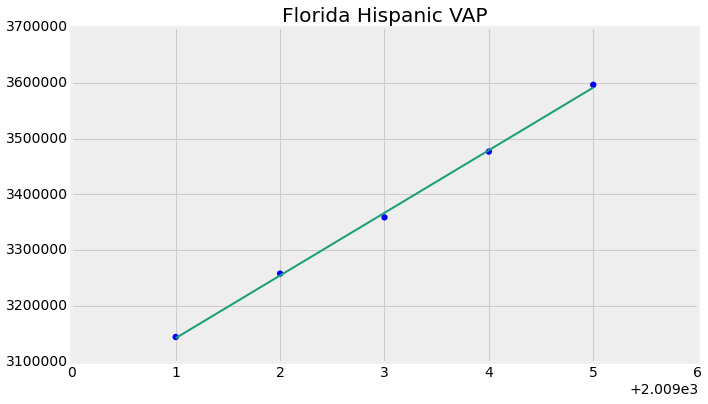

In [174]:
sample = get_sample('Florida', origin='hispanic')
pops, m, b = regress(sample)
plot_reg(pops, m, b, title="Florida Hispanic VAP")

In [154]:
sample = get_sample('Florida', origin='hispanic')
pops, m, b = regress(sample)
pops = dict(pops)
pop_2016 = m*2016 + b
pop_2016/pops[2014] - 1

0.061031368127492769

In [142]:
growth_rates = []
for i, row in fips_codes.iterrows():
    state = row['state_name']
    state_code = row['postal_code']
    for race in race_combos:
        sample = get_sample(state, race=race)
        pops, m, b = regress(sample)
        pops = dict(pops)
        growth_rates.append({'state_code': state_code, 'growth_rate': (m * 2016 + b) / pops[2014] - 1, 'group': race})
    
    sample = get_sample(state, origin='hispanic')
    pops, m, b = regress(sample)
    pops = dict(pops)
    growth_rates.append({'state_code': state_code, 'growth_rate': (m * 2016 + b) / pops[2014] - 1, 'group': 'hispanic'})

In [143]:
growth_rates = pd.DataFrame(growth_rates)
# growth_rates.to_csv('growth_rates.csv', index=False)

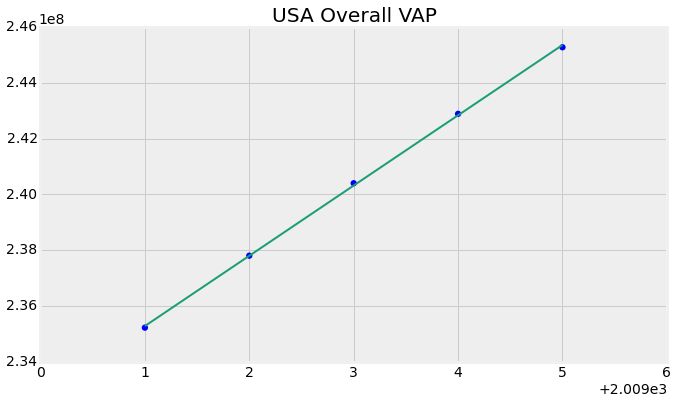

0.020863085060198516

In [175]:
# overall VAP
sample = pop_est[(pop_est['sex'] == 'total') & (pop_est['origin'] == 'total') & (pop_est['age'] >= 18)]
pops, m, b = regress(sample)
plot_reg(pops, m, b, title="USA Overall VAP")
pops = dict(pops)
pop_2016 = m*2016 + b
pop_2016/pops[2014] - 1